In [1]:
import torch
import scanpy as sc
import scDiffusion as sd


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = 'data/'
OUTPUT_PATH = 'outputs/'

# Load dataset

We privide a testing dataset, Cortex, for clustering task. The Cortex dataset is first published by Zeisel, A. et al. Science 347, 1138-1142 (2015). It contains single-cell RNA measurements of cells from two regions of the mouse cerebral cortex: the somatosensory cortex and hippocampus CA1. The dataset was reprocessed by Gayoso, A. et al. Nat Biotechnol 40, 163-166 (2022). Download the testing dataset from Google drive: https://drive.google.com/drive/folders/1l2CFg368I_H6ghzfyrX1WNkUeAvcUENm?usp=share_link.

In [4]:
adata = sc.read_h5ad(DATA_PATH+'cortex.h5ad')
adata

AnnData object with n_obs × n_vars = 3005 × 19972
    obs: 'labels'
    var: 'gene_ids', 'feature_types'

# Preprocess

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


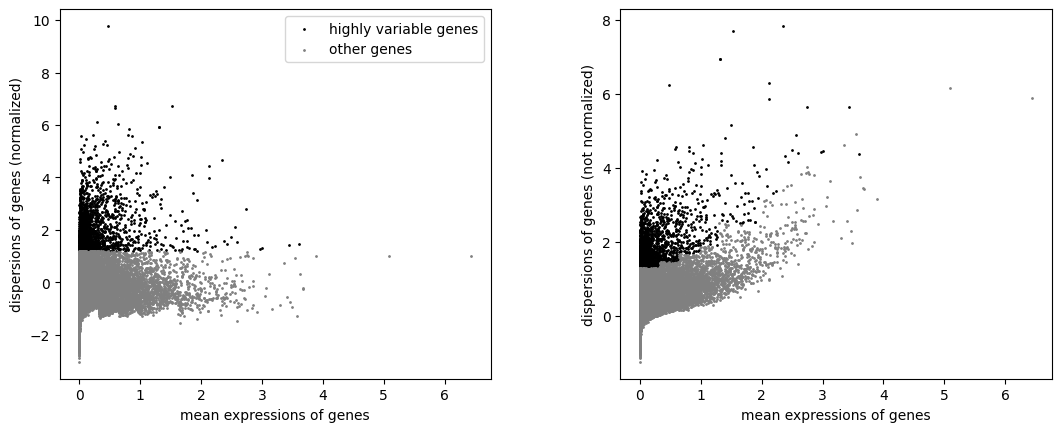

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [6]:
adata.raw = adata

adata = adata[:, adata.var.highly_variable]
adata


View of AnnData object with n_obs × n_vars = 3005 × 2000
    obs: 'labels'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [7]:
sd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], 
                   D_decode_list=[50, 300, 2000], 
                   max_epoch=2000, lr=1e-3, 
                   device=device)


2024-10-17 12:09:25,258 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2024-10-17 12:09:26,259 - ------------------------> Epoch: 1/2000, Current loss: 1433670.2500
2024-10-17 12:09:26,485 - ------------------------> Epoch: 51/2000, Current loss: 513299.9688
2024-10-17 12:09:26,690 - ------------------------> Epoch: 101/2000, Current loss: 441581.6875
2024-10-17 12:09:26,898 - ------------------------> Epoch: 151/2000, Current loss: 408883.5312
2024-10-17 12:09:27,091 - ------------------------> Epoch: 201/2000, Current loss: 392342.0938
2024-10-17 12:09:27,283 - ------------------------> Epoch: 251/2000, Current loss: 381197.9062


## Check isolated nodes (Not necessary)

In [8]:
sd.util.evaluate_node_isolation(adata, use_rep='X_fae', predict_pct=0.2)

The isolation inofrmation can be used to prune edges for single cell graph.

# Diffusion

In [9]:
# This graph provides the adjacency that will be used in diffusion loss function.
sd.graph.build_adj_graph(adata, use_rep=None, k=50, data_dtype = torch.float32, device=device)

In [10]:
sd.graph.build_diffusion_graph(adata, use_rep='X_fae', k=50, prune=False, device=device)


This graph is used in the graph neural diffusion process.

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [11]:
sd.graph_diffusion(adata, 
                   use_rep='X_fae', 
                   max_epoch=2000, 
                   lr=1e-3, 
                   time_increment_diffusion=0.2,  # Suggest value 0.0-0.5
                   loss_adj=0.0,
                   edge_rewire=True, # Default True. Set as False to accelerate the training process.
                   device=device)


2024-10-17 12:09:35,239 - --------> Starting graph nueral diffusion ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/graph_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adjacency, dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/graph_DIF.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(target_features, dtype = out_nodes_features.dtype)
2024-10-17 12:09:35,432 - ------------------------> Epoch: 1/2000, Current loss: 2649454.7500
2024-10-17 12:09:37,381 - ------------------------> Epoch: 51/2000, Current loss: 520408.1875
2024-10-17 12:09:39,341 - ------------------------> Epoch: 

Edge rewiring during the diffusion process typically increases the separation between cell groups while making each group more condensed. Set edge_rewire to True if you want to organize your data into more distinct clusters. Setting edge_rewire to False may preserve more inter-cluster relationships and appreciably accelerate the training process.

## View UMAP for diffused embeddings

In [12]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


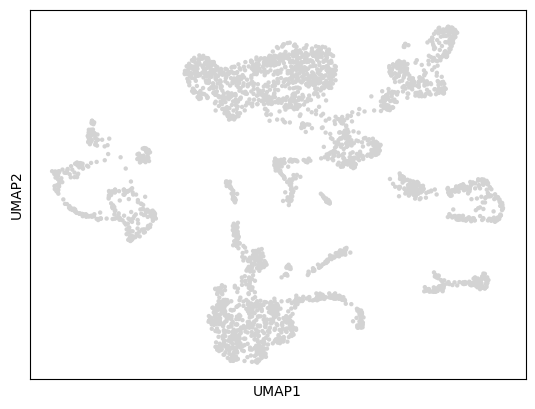

In [13]:
sc.pl.umap(adata)

# Clustering

In [14]:
sd.graph.build_graph(adata, use_rep="X_dif", k=50, device=device)

In [15]:
sd.graph.call_attention(adata, device=device)

In [16]:
sd.anal.att_leiden(adata, resolution=0.5)

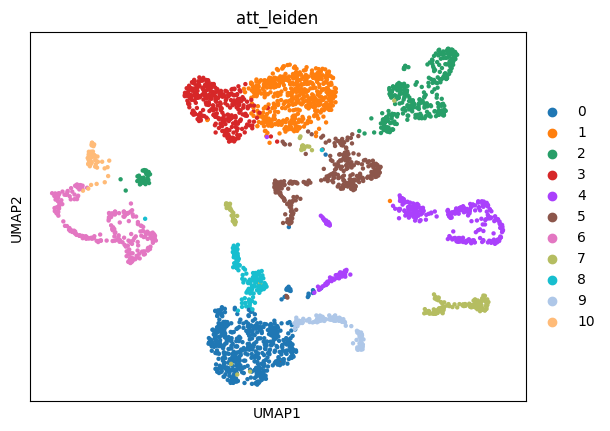

In [17]:
sc.pl.umap(adata, color=['att_leiden'])

# Save data

In [18]:
adata.write(OUTPUT_PATH+'scDiffusion_adata.h5ad')

In [19]:
adata = sc.read_h5ad(OUTPUT_PATH+'scDiffusion_adata.h5ad')